In [1]:
import pprint
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import folium
from folium.plugins import MarkerCluster, HeatMap

plt.style.use('ggplot')
%matplotlib inline

In [2]:
brs = pd.read_csv('bar_data.csv', 
                 sep='\t', 
                 names=['id', 'alias', 'name', 'review_count', 'rating', 
                        'lat', 'lng', 'addr1', 'addr2', 'addr3', 'city', 
                        'zip', 'country', 'state']).drop_duplicates(subset='alias')

crm = pd.read_csv('police_data.csv', 
                 names=['incident','offense_descr','offense_code',
                'fam_violence','occurred_date_time','occurred_date','occurred_time',
                'report_date_time','report_date','report_time','location_type',
                'address','zip','district','apd_sector','apd_district','pra',
                'census_tract','clearance_status','clearance_date','ucr_category',
                'category_descr','x_coord','y_coord','lat','lng','location'])
crm = crm[['offense_descr','occurred_date','report_date','category_descr','lat','lng']]
crm['occurred_date'] = pd.to_datetime(crm['occurred_date'])
crm['year'] = crm['occurred_date'].dt.year
crm = crm[crm['year'] >= 2015]
crm = crm[~crm['lat'].isnull()]

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
print(f'There are {brs["alias"].count()} bars in Austin')

There are 797 bars in Austin


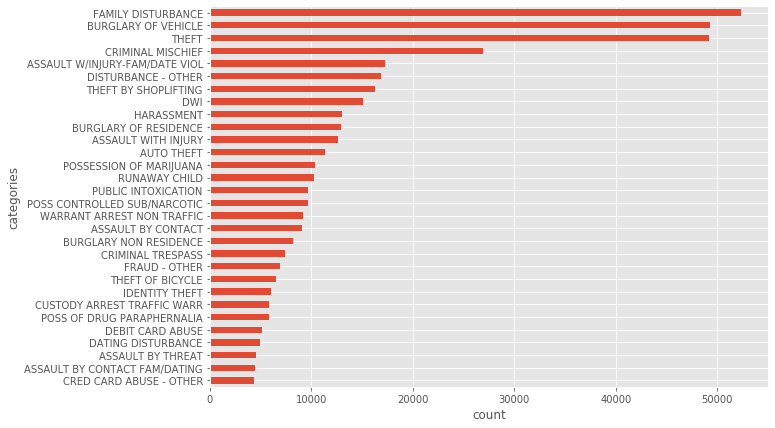

In [28]:
off_desc = crm[['offense_descr', 'occurred_date']].groupby('offense_descr')\
            .count().sort_values('occurred_date', ascending=False).rename(columns={'occurred_date': 'count'})
plot = off_desc.iloc[:30].plot.barh(y='count', figsize=(10,7), legend=False)
_ = plt.xlabel('count')
_ = plt.ylabel('categories')
plt.gca().invert_yaxis()

In [5]:
# print(br[['incident','occurred_date']].max())
# print(br[['incident','occurred_date']].min())

# pub_int = crm[crm['offense_descr'] == 'PUBLIC INTOXICATION']
# pub_int = pub_int[~pub_int['lat'].isnull()]

In [42]:
map_df = crm[crm['offense_descr'] == 'PUBLIC INTOXICATION'].loc[:, ('occurred_date', 'lat', 'lng')]
sub_setmap = map_df[:10000]
austin_map = folium.Map(location=['30.264980', '-97.746597'], tiles='Stamen Terrain', zoom_start=11)
# austin_map = folium.Map(location=['30.264980', '-97.746597'], tiles='Stamen Toner', zoom_start=11)
# austin_map = folium.Map(location=['30.264980', '-97.746597'], zoom_start=11)

HeatMap(data=sub_setmap[['lat', 'lng']].values.tolist(), radius=7, max_zoom=13).add_to(austin_map)

austin_map

In [14]:
# map_df = mod_df[['cost','source','lat','lon']]
# # sub_setmap = map_df.query("source == 'reator'")
# sub_setmap = map_df[:2000]
# austin_map = folium.Map(location=['30.264980', '-97.746597'], zoom_start =10)

# mc = MarkerCluster()

# for row in sub_setmap.itertuples():
#     mc.add_child(folium.Marker(location=[row.lat,row.lon], popup=[row.cost]))

In [20]:
def bars_in_box(upper, lower, left, right, df):
    return df[(df['lat'] > lower) & (df['lat'] <= upper) & \
                 (df['lng'] > left) & (df['lng'] <= right)]['lat'].count()

There are 348 bars in the region
There's an average 0.295 per subregion


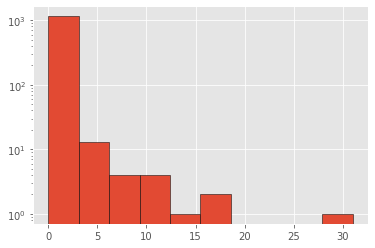

In [34]:
def get_bars_from_grid(df, tl, tr, bl, br, step=.002):
    topleft_lat = tl[0]
    topleft_lng = tl[1]
    bars_in_grid = []
    
    while topleft_lat + step > bl[0]:
        if topleft_lng + step > tr[1]:
            topleft_lng = tl[1]
            topleft_lat -= step
        while topleft_lng + step < tr[1]:
            bars_in_grid.append(bars_in_box(topleft_lat, topleft_lat - step, topleft_lng, topleft_lng + step, df))
            topleft_lng += step
    
    return bars_in_grid


tl = 30.3335, -97.7707
tr = 30.3335, -97.7077
bl =  30.2631, -97.7707
br = 30.2631, -97.7077
bars_in_grid = get_bars_from_grid(brs[['lat','lng']], tl, tr, bl, br)
bars_mean = np.mean(bars_in_grid)
print(f'There are {np.sum(bars_in_grid)} bars in the region')
print(f'There\'s an average {bars_mean:1.3f} per subregion')



fig, ax = plt.subplots()
plot = ax.hist(bars_in_grid, edgecolor='k')
plt.yscale('log')


# Note: Passing through the whole region as one yields 289 bars
# while iterating yields 348. Why is this?
#     Could be double counting
#     Could be grabbing bars on the edge, past the map.
#         Can't be double counting because going .002 outside the
#         right and bottom yields 325 total.

In [22]:
# print(bars_in_box(tl[0], tl[0]-20*step, tl[1], tr[1], brs[['lat','lng']]))
# print(bars_in_box(tl[0], bl[0], tl[1], tr[1], brs[['lat','lng']]))# gets all bars in area
# print(bars_in_box(tl[0], bl[0]-.002, tl[1], tr[1]+.002, brs[['lat','lng']]))# gets all bars in area + padding

In [23]:
alpha = 0.05
n_tests = 6
adj_alpha = alpha/n_tests

In [24]:
def get_bars_from_crimes(df1, crimes, col='PUBLIC INTOXICATION', step=.002):
    df2 = crimes[crimes['offense_descr'] == col].loc[:, ('lat', 'lng')]
    step = .002
    bars_in_range = []
    for index, row in df2.iterrows():
        if row['lat'] <= tl[0] and row['lat'] > br[0] and row['lng'] >= tl[1] and row['lng'] < br[1]:
            bars = bars_in_box(row['lat'] + step/2, row['lat'] - step/2, row['lng'] - step/2, row['lng'] + step/2, df1)
            bars_in_range.append(bars)
    
    return bars_in_range

Text(0.5, 0.98, 'Number of Bars Near Crimes')

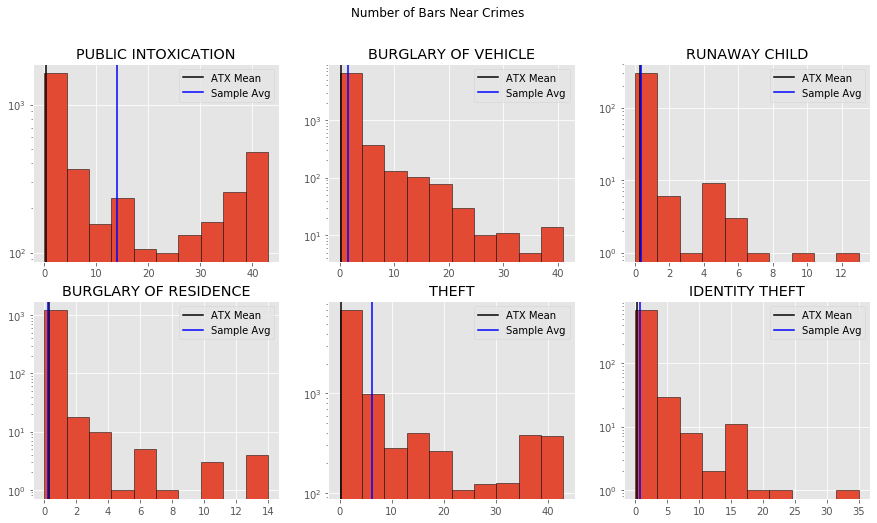

In [49]:
top_offenses = ['PUBLIC INTOXICATION', 'BURGLARY OF VEHICLE', 'RUNAWAY CHILD', \
                'BURGLARY OF RESIDENCE', 'THEFT', 'IDENTITY THEFT']
fig, axes = plt.subplots(2,3, figsize=(15,8))

t_stats = []
pvals = []
for ax, cat in zip(axes.flatten(), top_offenses):
    data = get_bars_from_crimes(brs, crm, cat)
    ax.hist(data, edgecolor='k')
    ax.axvline(bars_mean, c='k', label='ATX Mean')
    ax.axvline(np.mean(data), c='b', label='Sample Avg')
    ax.set_title(cat)
    ax.set_yscale('log')
    ax.legend()
    
    t_stat, pval = stats.ttest_1samp(data, bars_mean)
    pvals.append(pval)
    t_stats.append(t_stat)

plt.suptitle("Number of Bars Near Crimes")
plt.title()
# plt.legend()

In [50]:
for i in range(len(top_offenses)):
    if pvals[i] < adj_alpha:
        print(f'{top_offenses[i]}: p value = {pvals[i]:1.4f}. This is less than {adj_alpha:1.4f} so we reject the null hypothesis')
    else:
        print(f'{top_offenses[i]}: p value = {pvals[i]:1.4f}. This is greater than {adj_alpha:1.4f} so we fail to reject the null hypothesis')

PUBLIC INTOXICATION: p value = 0.0000. This is less than 0.0083 so we reject the null hypothesis
BURGLARY OF VEHICLE: p value = 0.0000. This is less than 0.0083 so we reject the null hypothesis
RUNAWAY CHILD: p value = 0.4210. This is greater than 0.0083 so we fail to reject the null hypothesis
BURGLARY OF RESIDENCE: p value = 0.0588. This is greater than 0.0083 so we fail to reject the null hypothesis
THEFT: p value = 0.0000. This is less than 0.0083 so we reject the null hypothesis
IDENTITY THEFT: p value = 0.0000. This is less than 0.0083 so we reject the null hypothesis
